# Methoden en Technieken -- Blok 2

## Datapunt Opdracht

In deze opdracht worden de volgende leeruitkomsten getoetst, relevante termen zijn **dik** gedrukt:
- B2: Je stelt op basis van requirements een **geschikte architectuur** voor een AI-oplossing op en selecteert daarvoor passende AI-technieken, gebruik makend van **machine learning**, **deep learning**, **kennisrepresentatie**, **computer vision** en natural language processing.
- B3: Je prepareert een dataset voor het **trainen en testen** van een AI-model rekening houdend met technische en ethische randvoorwaarden.
- B4: **Je ontwikkelt, traint en evalueert een AI-model** volgens een **iteratief proces**.
- C2: **Je evalueert en beoordeelt de kwaliteit van een AI-model aan de hand van kwaliteitscriteria** die in het vakgebied erkend worden waaronder robustness, **performance**, scalability, explainability, model complexity en resource demand.

## De opdracht

In de slides van les 12 word beschreven hoe we een Deep Belief Netwerk unsupervised trainen op de MNIST data. 

In deze opdracht gaan we dit gebruiken om een MNIST classifier semi-supervised te trainen. We doen hier alsof slechts 500 van de 70000 MNIST afbeeldingen gelabeld zijn (zie code hieronder, deze maakt de data aan die je mag gebruiken). Je zult dus:
- Een DBN unsupervised trainen op de data
- Een classifier trainen op de latent space van de DBN en de gelabelde data

Je mag zelf kiezen:
- De architectuur van de DBN (let op, deze zal wat tijd kosten om te trainen)
- De classifier op de latent space (alles is toegestaan)
- Hoe je de modellen beoordeelt

Probeer een zo'n goed mogelijk model te krijgen (in een redelijke tijd), verantwoord je keuzes. Bespreek je uiteindelijke model in detail, eerdere pogingen/modellen mogen korter besproken worden.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import BernoulliRBM
from ipywidgets import interactive
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import torch.nn.functional as F
from sklearn.dummy import DummyClassifier

In [2]:
(x1, y), (x2, _) = keras.datasets.mnist.load_data()
x = np.concatenate((x1, x2))

x = np.expand_dims(x, -1).astype("float32") / 255

y = y[:500]

del x1, x2

In [3]:
# Select the first 500 labels as labeled data
labeled_x = x[:500]
labeled_y = y[:500]

# The rest are unlabeled data
unlabeled_x = x[500:]

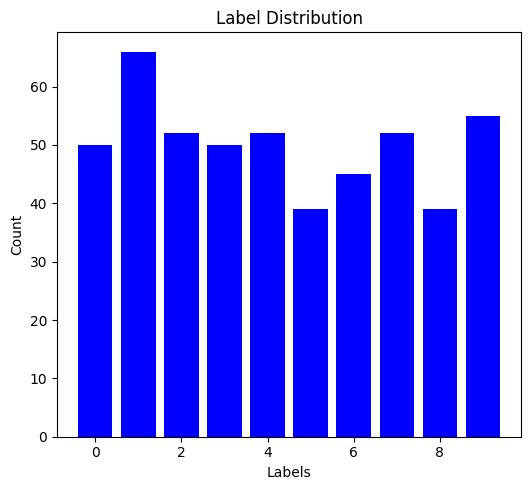

In [26]:
y_labeled = keras.utils.to_categorical(labeled_y, 10)

# Convert one-hot encoded labels back to single integer labels
y_labels = np.argmax(y_labeled, axis=1)

# Count the number of occurrences of each label
label_counts = np.bincount(y_labels)

# Define the labels
labels = range(10)

# Plot the label counts for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(labels, label_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')

plt.tight_layout()
plt.show()

The numbers seem to be reasonably balanced.

In [4]:
X_labeled_train, x_labeled_remaining, y_labeled_train,  y_labeled_remaining = train_test_split(labeled_x, labeled_y, test_size=0.3, random_state = 42)
X_labeled_validation, X_labeled_test,y_labeled_validation,  y_test = train_test_split(x_labeled_remaining, y_labeled_remaining, test_size=0.5, random_state = 42)
y_labeled_train = keras.utils.to_categorical(y_labeled_train, 10)
y_labeled_validation = keras.utils.to_categorical(y_labeled_validation, 10)
y_labeled_test = keras.utils.to_categorical(y_test, 10)

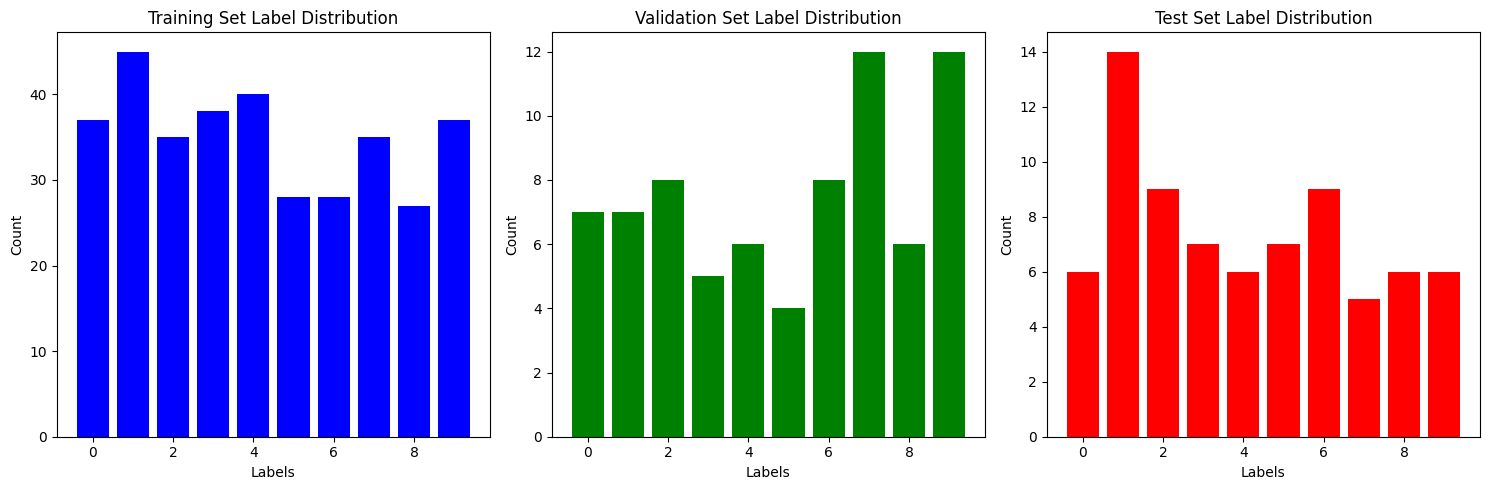

In [5]:
# Convert one-hot encoded labels back to single integer labels
y_train_labels = np.argmax(y_labeled_train, axis=1)
y_val_labels = np.argmax(y_labeled_validation, axis=1)
y_test_labels = np.argmax(y_labeled_test, axis=1)

# Count the number of occurrences of each label
train_label_counts = np.bincount(y_train_labels)
val_label_counts = np.bincount(y_val_labels)
test_label_counts = np.bincount(y_test_labels)

# Define the labels
labels = range(10)

# Plot the label counts for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(labels, train_label_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')

plt.subplot(1, 3, 2)
plt.bar(labels, val_label_counts, color='green')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Validation Set Label Distribution')

plt.subplot(1, 3, 3)
plt.bar(labels, test_label_counts, color='red')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Test Set Label Distribution')

plt.tight_layout()
plt.show()

The data is niceley split, but some labels are a bit sparce so it a new and stratisfied split would be a good idea.

In [6]:
X_labeled_train, x_labeled_remaining, y_labeled_train,  y_labeled_remaining = train_test_split(labeled_x, labeled_y, test_size=0.3, random_state = 2, stratify=labeled_y)
X_labeled_validation, X_labeled_test,y_labeled_validation,  y_test = train_test_split(x_labeled_remaining, y_labeled_remaining, test_size=0.5, random_state = 2, stratify=y_labeled_remaining)
y_labeled_train = keras.utils.to_categorical(y_labeled_train, 10)
y_labeled_validation = keras.utils.to_categorical(y_labeled_validation, 10)
y_labeled_test = keras.utils.to_categorical(y_test, 10)

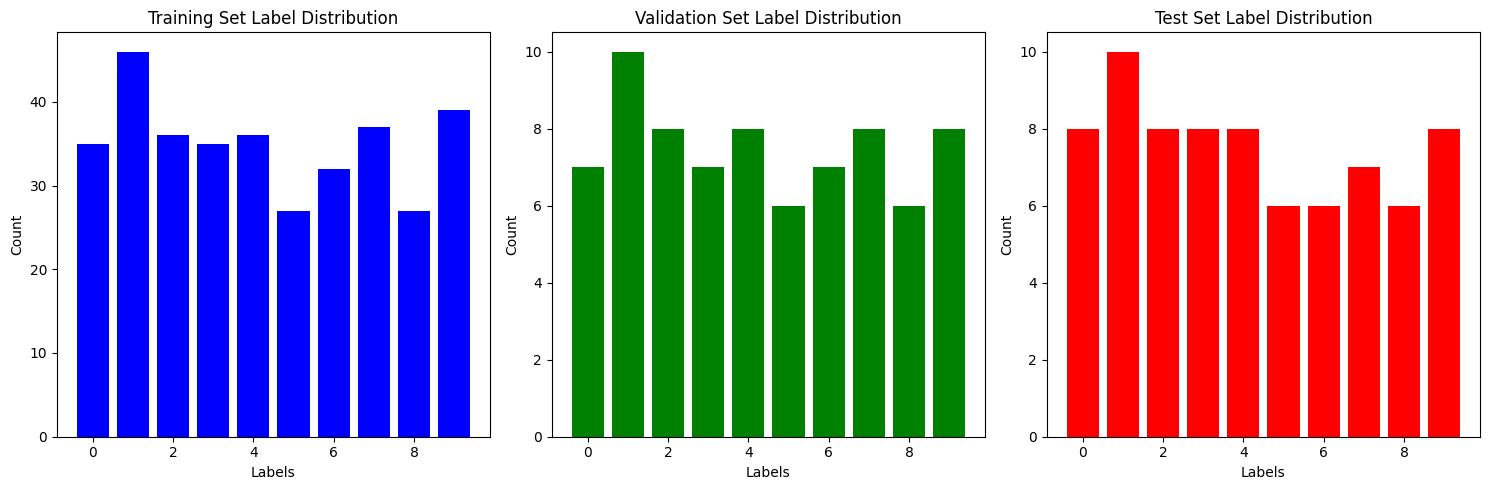

In [7]:
# Convert one-hot encoded labels back to single integer labels
y_train_labels = np.argmax(y_labeled_train, axis=1)
y_val_labels = np.argmax(y_labeled_validation, axis=1)
y_test_labels = np.argmax(y_labeled_test, axis=1)

# Count the number of occurrences of each label
train_label_counts = np.bincount(y_train_labels)
val_label_counts = np.bincount(y_val_labels)
test_label_counts = np.bincount(y_test_labels)

# Define the labels
labels = range(10)

# Plot the label counts for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(labels, train_label_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')

plt.subplot(1, 3, 2)
plt.bar(labels, val_label_counts, color='green')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Validation Set Label Distribution')

plt.subplot(1, 3, 3)
plt.bar(labels, test_label_counts, color='red')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Test Set Label Distribution')

plt.tight_layout()
plt.show()

Not only is there plenty of data for each label now, the proportions of the labels is also the same in each dataset.

In [8]:
unlabeled_x = unlabeled_x.reshape(len(unlabeled_x), -1)
X_labeled_train = X_labeled_train.reshape(len(X_labeled_train), -1)
X_labeled_validation = X_labeled_validation.reshape(len(X_labeled_validation), -1)
X_labeled_test = X_labeled_test.reshape(len(X_labeled_test), -1)

# Evaluation metrics

The evaluation metrics used will be the accuracy score.

Accuracy has been chosen because no single number is more important than another, and the dataset is perfectly balanced, so there is no risk of any label being overlooked.

# Null model

Het nulmodel will be the most frequent number.

In [19]:
# Convert one-hot encoded labels back to class labels
y_train = np.argmax(y_labeled_train, axis=1)
y_val = np.argmax(y_labeled_test, axis=1)

# Create the DummyClassifier with the 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the classifier on the training data
dummy_clf.fit(X_labeled_train, y_train)

In [ ]:
# Predict on the validation data
y_pred_classes = dummy_clf.predict(X_labeled_validation)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Print classification report
print(classification_report(y_val, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.13      1.00      0.24        10
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         8

    accuracy                           0.13        75
   macro avg       0.01      0.10      0.02        75
weighted avg       0.02      0.13      0.03        75



d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The accuracy of the null model is 13%.

# Model choice

This is the base RBM from lession 12.

The other algorithms have a latent space of 45 from wich they have to make their own predictions.

In [158]:
hidden_sizes = [364, 91, 45]

In [ ]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 100, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.52s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.34s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.36s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.35s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.37s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.44s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.43s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.43s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.45s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.50s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.45s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.49s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.54s
[BernoulliRBM] Iteration

In [ ]:
with open('DBN_2B_0.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [159]:
with open('DBN_2B_0.pickle', 'rb') as file:
    RBMs = pickle.load(file)

Put the RBMs in a pytorch model so I can get the predictions out of it.

In [160]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
)


In [161]:
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

model.eval()
model_output = model(X_val)
model_output = model_output.detach().numpy()

## Models

To choose a model I will run the canidate models on their base settings and choose the one with the highest accuracy.

### Decicion trees

### Decicion tree

The RBM output is 45 parts of an number that together should tell what the number is.

And simple decicion tree migth be able to tell the for example an output of 2 times 0 makes an 8.

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt.fit(X_labeled_train, y_labeled_train)

# Predict on the test set
y_pred = dt.predict(X_labeled_validation)

# Evaluate the model
accuracy = accuracy_score(y_labeled_validation, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 53.33%


The disicion tree has an accuracy of 53%.

### Random forrest

Now, a more advanced version of the decision tree, the RandomForestClassifier, will be tested.

In the latent space of 45 items, there will also be some vague letter parts. Compared to a normal decision tree, the RandomForestClassifier will be better able to learn which vague letter parts make up entire letters. Hopefully, it will be able to create some trees for each letter based on a lot of vague letter parts.

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf.fit(X_labeled_train, y_labeled_train)

# Predict on the test set
y_pred = rf.predict(X_labeled_validation)

# Evaluate the model
accuracy = accuracy_score(y_labeled_validation, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 60.00%


It seems that the extra if else statements made the model less accurate with an accuracy of 60%.

### KNN

There are only 10 labels, that should look alike.

Because of this reason they should be close in the latent space of the RBM with a size of 45.

This means a KNeighborsClassifier should be able to predict the number reasonably.

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=10)

# Train the k-NN model
knn.fit(X_labeled_train, y_labeled_train)

# Predict on the test set
y_pred = knn.predict(X_labeled_validation)

# Evaluate the model
accuracy = accuracy_score(y_labeled_validation, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 69.33%


The accuracy of KNeighborsClassifier is 69%.

### SVC

Just like KNN, Support Vector Classifiers (SVC) are also good at recognizing items based on their location in a latent space.

In [125]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Support Vector Machine classifier
svm = SVC(kernel='linear', random_state=42)

# Wrap the SVM classifier with OneVsRestClassifier
ovr = OneVsRestClassifier(svm)

# Train the OneVsRestClassifier model
ovr.fit(X_labeled_train, y_labeled_train)

# Predict on the test set
y_pred = ovr.predict(X_labeled_validation)

# Evaluate the model
accuracy = accuracy_score(y_labeled_validation, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 78.67%


It seems that the SVC has an accuracy of 79%.

### Neural network

The last model to be tested will be a neural network.

The neural network should be able to better recognize patterns in the latent space of 45 dimensions, distinguishing between different shapes such as circles and lines, and use this information to correctly identify the corresponding number.

In [162]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        
        x = torch.sigmoid(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store loss and validation loss
train_losses1 = []
val_losses1 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses1.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses1.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.1467, Val Loss: 2.1857
Epoch [2/100], Loss: 2.0536, Val Loss: 2.0859
Epoch [3/100], Loss: 1.9512, Val Loss: 2.0067
Epoch [4/100], Loss: 1.8870, Val Loss: 1.9451
Epoch [5/100], Loss: 1.8194, Val Loss: 1.8965
Epoch [6/100], Loss: 1.7736, Val Loss: 1.8584
Epoch [7/100], Loss: 1.7399, Val Loss: 1.8276
Epoch [8/100], Loss: 1.7068, Val Loss: 1.8026
Epoch [9/100], Loss: 1.6856, Val Loss: 1.7817
Epoch [10/100], Loss: 1.6635, Val Loss: 1.7650
Epoch [11/100], Loss: 1.6457, Val Loss: 1.7497
Epoch [12/100], Loss: 1.6302, Val Loss: 1.7365
Epoch [13/100], Loss: 1.6181, Val Loss: 1.7251
Epoch [14/100], Loss: 1.6054, Val Loss: 1.7151
Epoch [15/100], Loss: 1.5944, Val Loss: 1.7062
Epoch [16/100], Loss: 1.5853, Val Loss: 1.6981
Epoch [17/100], Loss: 1.5757, Val Loss: 1.6913
Epoch [18/100], Loss: 1.5704, Val Loss: 1.6843
Epoch [19/100], Loss: 1.5642, Val Loss: 1.6784
Epoch [20/100], Loss: 1.5572, Val Loss: 1.6729
Epoch [21/100], Loss: 1.5522, Val Loss: 1.6678
Epoch [22/100], Loss: 

In [164]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print classification report
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10
           2       0.89      1.00      0.94         8
           3       0.83      0.71      0.77         7
           4       1.00      1.00      1.00         8
           5       0.80      0.67      0.73         6
           6       1.00      0.86      0.92         7
           7       1.00      0.62      0.77         8
           8       0.86      1.00      0.92         6
           9       0.67      1.00      0.80         8

    accuracy                           0.89        75
   macro avg       0.90      0.89      0.89        75
weighted avg       0.91      0.89      0.89        75



The neural network has an accuracy of 89% meaning that this is by far the best model.

# Jelmar

Just so it is easier for you to grade, every time I made a decicion I put my name above it from here all the way to the end of the document.

# Iteration 0

Also known as the base model.

In [165]:
hidden_sizes = [364, 91, 45]

In [ ]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 100, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.52s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.34s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.36s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.35s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.37s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.44s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.43s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.43s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.45s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.50s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.45s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.49s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.54s
[BernoulliRBM] Iteration

The pseudo-likelihood is how confident the model is in predicting, but it does not say if the model is overfitting or underfitting.

In [242]:
with open('DBN_2B_0.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [166]:
with open('DBN_2B_0.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [244]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

RBM inner representatation of the number.

In [245]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))
        

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

How good the model is at recognising the numbers.

In [246]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

# Jelmar

So the activation function of the RBM layers has to be sigmoid for it to work with the bias enabled.

To start small there is only one pytorch layer after the RBM with 10 nodes because that is also the output of the model.

For the last activation function, I was considering either sigmoid or ReLU. Using sigmoid would extend the RBM formula to the output layer, maintaining consistency with the previous layers. On the other hand, ReLU would introduce its own non-linearity independently. Since the sigmoid function is also the standard option for multilabel classification, the base model will use the sigmoid activation function. Other activation functions will be tested in later iterations.


In [167]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        
        x = torch.sigmoid(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


# Jelmar
The criterion CrossEntropyLoss will be used since that is the standart for multilabel classification.

The optimizer Adam will be used with the default parameters including the default learning rate of 0.001.

The batch size is set to 2 because there are only 10 nodes being trained. With a small dataset, a smaller batch size allows the model to gain more detailed knowledge from each item.

In [168]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store loss and validation loss
train_losses1 = []
val_losses1 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses1.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses1.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.1107, Val Loss: 2.1784
Epoch [2/100], Loss: 2.0052, Val Loss: 2.0786
Epoch [3/100], Loss: 1.9252, Val Loss: 2.0031
Epoch [4/100], Loss: 1.8674, Val Loss: 1.9439
Epoch [5/100], Loss: 1.8106, Val Loss: 1.8969
Epoch [6/100], Loss: 1.7759, Val Loss: 1.8597
Epoch [7/100], Loss: 1.7434, Val Loss: 1.8292
Epoch [8/100], Loss: 1.7144, Val Loss: 1.8046
Epoch [9/100], Loss: 1.6945, Val Loss: 1.7838
Epoch [10/100], Loss: 1.6722, Val Loss: 1.7666
Epoch [11/100], Loss: 1.6568, Val Loss: 1.7515
Epoch [12/100], Loss: 1.6423, Val Loss: 1.7385
Epoch [13/100], Loss: 1.6271, Val Loss: 1.7270
Epoch [14/100], Loss: 1.6174, Val Loss: 1.7170
Epoch [15/100], Loss: 1.6098, Val Loss: 1.7082
Epoch [16/100], Loss: 1.5959, Val Loss: 1.6999
Epoch [17/100], Loss: 1.5881, Val Loss: 1.6924
Epoch [18/100], Loss: 1.5793, Val Loss: 1.6861
Epoch [19/100], Loss: 1.5733, Val Loss: 1.6799
Epoch [20/100], Loss: 1.5669, Val Loss: 1.6750
Epoch [21/100], Loss: 1.5617, Val Loss: 1.6692
Epoch [22/100], Loss: 

In [169]:
# Save the model
torch.save(model.state_dict(), 'model_0.pth')
print("Model saved!")

Model saved!


In [76]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_0.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_17672\1992985865.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_0.pth'))


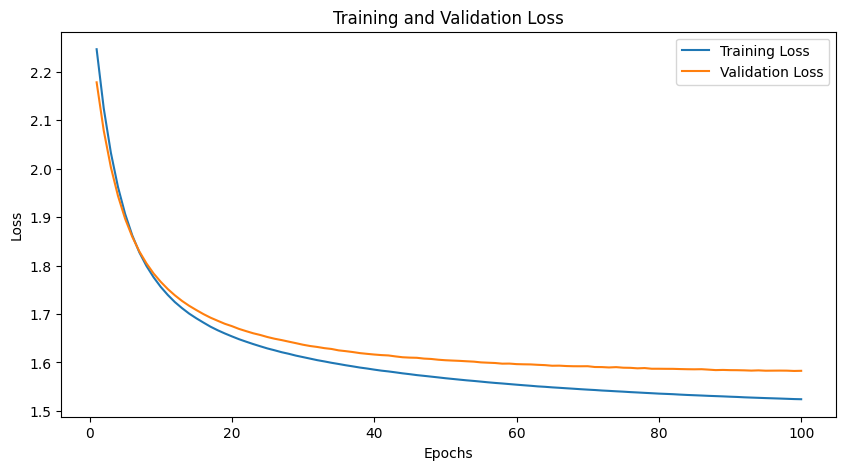

In [170]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

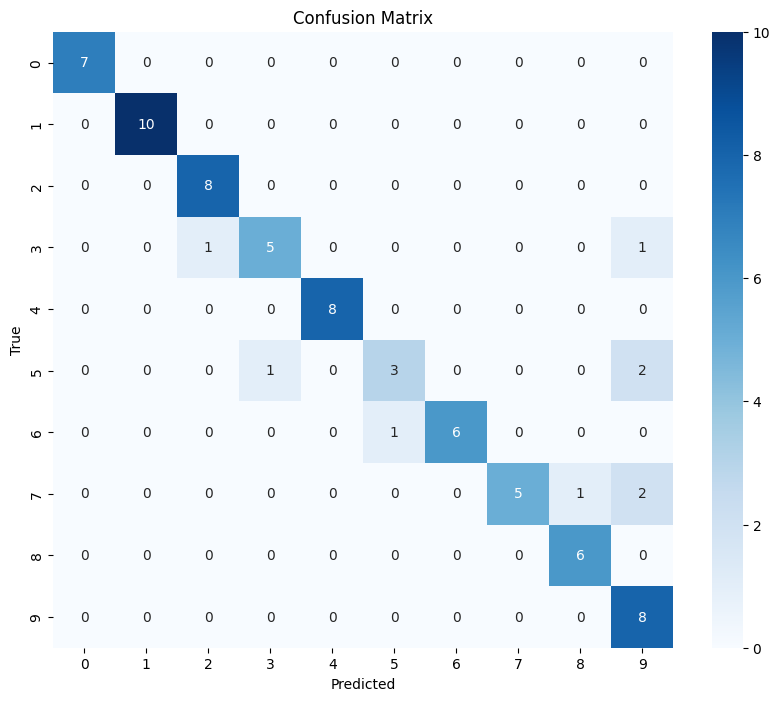

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10
           2       0.89      1.00      0.94         8
           3       0.83      0.71      0.77         7
           4       1.00      1.00      1.00         8
           5       0.75      0.50      0.60         6
           6       1.00      0.86      0.92         7
           7       1.00      0.62      0.77         8
           8       0.86      1.00      0.92         6
           9       0.62      1.00      0.76         8

    accuracy                           0.88        75
   macro avg       0.89      0.87      0.87        75
weighted avg       0.90      0.88      0.88        75



In [171]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))


# Iteration 1

On the first itteration the activation fuction of the pytorch layer will be changed, because sigmoid has been chosen as a base function while this is the basis for multilabel classification.  Adding non-linearity to the model should improve its ability to find more complex patterns.

In [172]:
hidden_sizes = [364, 91, 45]

In [173]:
with open('DBN_2B_0.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In iteration 0 I had to start simple.

I was considering whether to keep the model's math straightforward and linear or to introduce non-linearity. The SiLU (Sigmoid Linear Unit) function combines the properties of both ReLU and sigmoid activation functions. This means the SiLU function can effectively handle the inputs from the linear RBM layers while also introducing the non-linearity to the model.

In [174]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [175]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store loss and validation loss
train_losses_1 = []
val_losses_1 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses_1.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses_1.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.1128, Val Loss: 2.0283
Epoch [2/100], Loss: 1.4508, Val Loss: 1.6087
Epoch [3/100], Loss: 0.9001, Val Loss: 1.2341
Epoch [4/100], Loss: 0.5904, Val Loss: 0.9952
Epoch [5/100], Loss: 0.4229, Val Loss: 0.8437
Epoch [6/100], Loss: 0.3304, Val Loss: 0.7427
Epoch [7/100], Loss: 0.2809, Val Loss: 0.6714
Epoch [8/100], Loss: 0.2224, Val Loss: 0.6193
Epoch [9/100], Loss: 0.1890, Val Loss: 0.5761
Epoch [10/100], Loss: 0.1650, Val Loss: 0.5414
Epoch [11/100], Loss: 0.1529, Val Loss: 0.5140
Epoch [12/100], Loss: 0.1343, Val Loss: 0.4929
Epoch [13/100], Loss: 0.1207, Val Loss: 0.4711
Epoch [14/100], Loss: 0.1139, Val Loss: 0.4578
Epoch [15/100], Loss: 0.0996, Val Loss: 0.4417
Epoch [16/100], Loss: 0.0996, Val Loss: 0.4306
Epoch [17/100], Loss: 0.0879, Val Loss: 0.4167
Epoch [18/100], Loss: 0.0804, Val Loss: 0.4044
Epoch [19/100], Loss: 0.0755, Val Loss: 0.3956
Epoch [20/100], Loss: 0.0709, Val Loss: 0.3878
Epoch [21/100], Loss: 0.0650, Val Loss: 0.3777
Epoch [22/100], Loss: 

In [177]:
# Save the model
torch.save(model.state_dict(), 'model_1.pth')
print("Model saved!")

Model saved!


In [78]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_1.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_17672\3365279233.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_1.pth'))


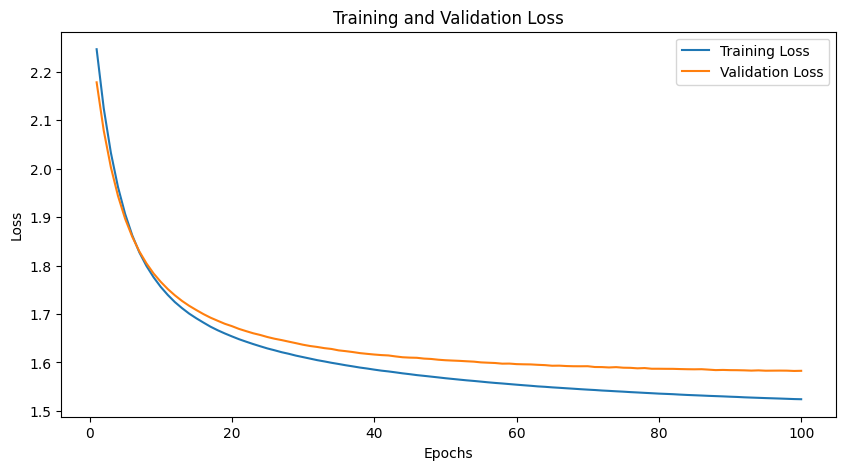

In [178]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

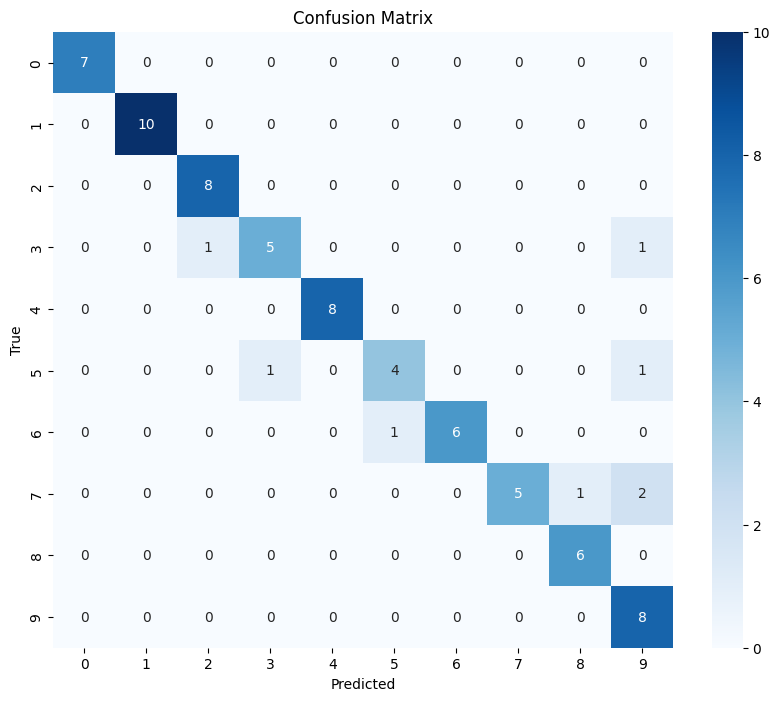

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10
           2       0.89      1.00      0.94         8
           3       0.83      0.71      0.77         7
           4       1.00      1.00      1.00         8
           5       0.80      0.67      0.73         6
           6       1.00      0.86      0.92         7
           7       1.00      0.62      0.77         8
           8       0.86      1.00      0.92         6
           9       0.67      1.00      0.80         8

    accuracy                           0.89        75
   macro avg       0.90      0.89      0.89        75
weighted avg       0.91      0.89      0.89        75



In [179]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Jelmar

This model has an accuracy of 89%, wich is one precent better than the base model.

# Iteration dead end 1

# Jelmar

Now that the foundation of the classification model is solid it is time to look at the RBM model.

To make it easier for the pytorch layers to predict what the RBM model want I will put 10 layers at the end like the 10 labels that the model trains on.

This should make it easier for the pytorch layer and it should also give me some insight on the RBM model itself, because by only training the RBM once I cannot see if it is overly complex, underly complex, overfit, underfit or anything else.

In [14]:
hidden_sizes = [364, 91, 45, 10]

In [126]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 100, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.62s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.37s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.42s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.42s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.38s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.38s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.40s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.45s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.46s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.50s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.43s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.50s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.52s
[BernoulliRBM] Iteration

In [127]:
with open('DBN_2B_D1.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [15]:
with open('DBN_2B_D1.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [16]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

In [17]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

In [18]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

# Jelmar

As can be seen in the images above, the Boltzmann machine starts to overfit on the training images. It tries to add so much detail to the letters that it starts to blur the line between some letters. The goal of the Boltzmann machine is not to generate good-looking images, but to correctly recognize the images.

In [182]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        self.rbm4 = nn.Linear(45, 10, bias=True)
        
        self.fc1 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        x = torch.sigmoid(self.rbm4(x))
        
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

    model.rbm4.weight.copy_(torch.tensor(RBMs[3].components_.T.T))
    model.rbm4.bias.copy_(torch.tensor(RBMs[3].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
for param in model.rbm4.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (rbm4): Linear(in_features=45, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
)


In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store loss and validation loss
train_losses_d1 = []
val_losses_d1 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses_d1.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses_d1.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.3415, Val Loss: 2.2637
Epoch [2/100], Loss: 2.2238, Val Loss: 2.1843
Epoch [3/100], Loss: 2.0361, Val Loss: 2.0950
Epoch [4/100], Loss: 1.7873, Val Loss: 1.9977
Epoch [5/100], Loss: 1.4976, Val Loss: 1.8934
Epoch [6/100], Loss: 1.2384, Val Loss: 1.7946
Epoch [7/100], Loss: 1.0199, Val Loss: 1.7024
Epoch [8/100], Loss: 0.8519, Val Loss: 1.6191
Epoch [9/100], Loss: 0.7597, Val Loss: 1.5446
Epoch [10/100], Loss: 0.6476, Val Loss: 1.4792
Epoch [11/100], Loss: 0.5662, Val Loss: 1.4217
Epoch [12/100], Loss: 0.5008, Val Loss: 1.3718
Epoch [13/100], Loss: 0.4373, Val Loss: 1.3275
Epoch [14/100], Loss: 0.4026, Val Loss: 1.2884
Epoch [15/100], Loss: 0.3508, Val Loss: 1.2543
Epoch [16/100], Loss: 0.3256, Val Loss: 1.2239
Epoch [17/100], Loss: 0.3010, Val Loss: 1.1961
Epoch [18/100], Loss: 0.2854, Val Loss: 1.1718
Epoch [19/100], Loss: 0.2534, Val Loss: 1.1494
Epoch [20/100], Loss: 0.2377, Val Loss: 1.1284
Epoch [21/100], Loss: 0.2201, Val Loss: 1.1102
Epoch [22/100], Loss: 

In [184]:
# Save the model
torch.save(model.state_dict(), 'model_d1.pth')
print("Model saved!")

Model saved!


In [143]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_d1.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_17672\3964580165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_d1.pth'))


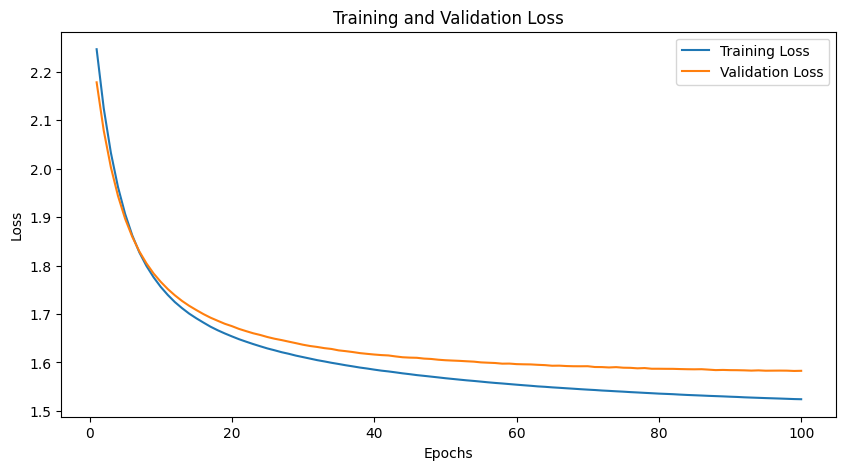

In [185]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

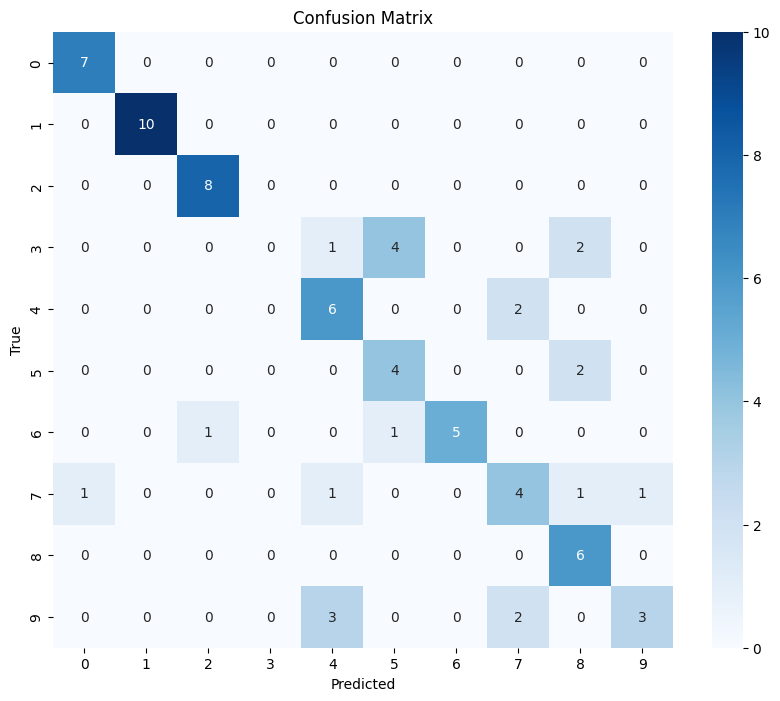

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00        10
           2       0.89      1.00      0.94         8
           3       0.00      0.00      0.00         7
           4       0.55      0.75      0.63         8
           5       0.44      0.67      0.53         6
           6       1.00      0.71      0.83         7
           7       0.50      0.50      0.50         8
           8       0.55      1.00      0.71         6
           9       0.75      0.38      0.50         8

    accuracy                           0.71        75
   macro avg       0.65      0.70      0.66        75
weighted avg       0.67      0.71      0.67        75



d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [186]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Jelmar

As discussed during the viewing of the generated images of the Boltzmann machine, it started overfitting. This is also evident in the confusion matrix, which looks significantly worse than in iteration 1.

Additionally, the accuracy has decreased from 89% to 71%.

# Iteration 2

# Jelmar

Since the model started to overfit in the last iteration when it became larger, it now needs to be investigated whether the base model was already overfitting.

In [9]:
hidden_sizes = [364, 91, 45]

# Jelmar

To test if the model was not overfitting already the number of itteration will be reduced from 100 to 50.

In [138]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 50, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.61s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.40s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.40s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.47s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.34s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.46s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.45s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.47s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.47s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.47s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.47s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.49s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.52s
[BernoulliRBM] Iteration

In [139]:
with open('DBN_2B_2.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [10]:
with open('DBN_2B_2.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [11]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

In [12]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

In [13]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

# Jelmar

The Boltzman machine now seems to get almost all if not all (it's hard to see with the human eye) the letters correctly identified.

In [203]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [190]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss and validation loss
train_losses2 = []
val_losses2 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses2.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses2.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.2189, Val Loss: 2.0402
Epoch [2/100], Loss: 1.5146, Val Loss: 1.6282
Epoch [3/100], Loss: 0.8665, Val Loss: 1.2543
Epoch [4/100], Loss: 0.5562, Val Loss: 1.0065
Epoch [5/100], Loss: 0.3688, Val Loss: 0.8455
Epoch [6/100], Loss: 0.2739, Val Loss: 0.7376
Epoch [7/100], Loss: 0.2270, Val Loss: 0.6619
Epoch [8/100], Loss: 0.1827, Val Loss: 0.6043
Epoch [9/100], Loss: 0.1575, Val Loss: 0.5607
Epoch [10/100], Loss: 0.1311, Val Loss: 0.5273
Epoch [11/100], Loss: 0.1141, Val Loss: 0.4962
Epoch [12/100], Loss: 0.0989, Val Loss: 0.4696
Epoch [13/100], Loss: 0.0889, Val Loss: 0.4486
Epoch [14/100], Loss: 0.0754, Val Loss: 0.4333
Epoch [15/100], Loss: 0.0727, Val Loss: 0.4177
Epoch [16/100], Loss: 0.0644, Val Loss: 0.4070
Epoch [17/100], Loss: 0.0603, Val Loss: 0.3893
Epoch [18/100], Loss: 0.0555, Val Loss: 0.3808
Epoch [19/100], Loss: 0.0502, Val Loss: 0.3736
Epoch [20/100], Loss: 0.0490, Val Loss: 0.3696
Epoch [21/100], Loss: 0.0444, Val Loss: 0.3554
Epoch [22/100], Loss: 

In [146]:
# Save the model
torch.save(model.state_dict(), 'model_2.pth')
print("Model saved!")

Model saved!


In [204]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_2.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_17672\1777792011.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2.pth'))


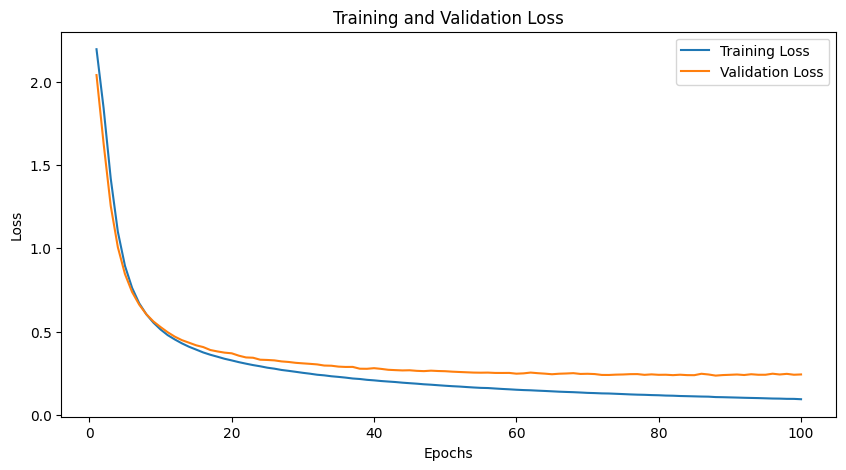

In [192]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses2, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

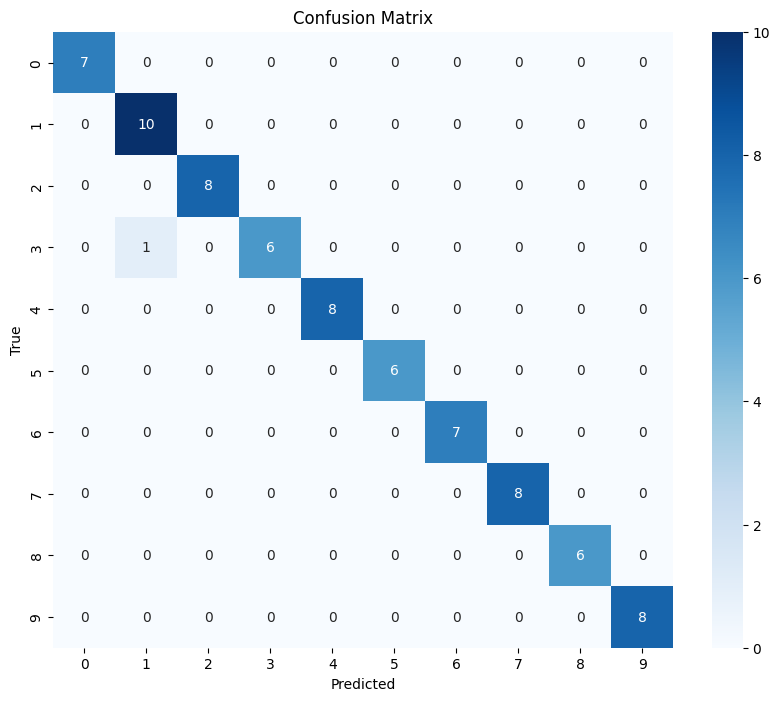

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.91      1.00      0.95        10
           2       1.00      1.00      1.00         8
           3       1.00      0.86      0.92         7
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         8

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



In [194]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Jelmar

The accuracy of the model is now 99%.

There is only a single mistake left so every new itteration would be myself manualy overfitting on the validation data.

# Conclusie

In [243]:
hidden_sizes = [364, 91, 45]

In [244]:
with open('DBN_2B_2.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [247]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [248]:
# Load the model
model.load_state_dict(torch.load('model_2.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_17672\1059811384.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2.pth'))


# Null model result

In [21]:
# Predict on the test data
y_test_classes = dummy_clf.predict(X_labeled_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_classes)

# Print classification report
print(classification_report(y_test, y_test_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.13      1.00      0.24        10
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         8

    accuracy                           0.13        75
   macro avg       0.01      0.10      0.02        75
weighted avg       0.02      0.13      0.03        75



d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Final iteration result

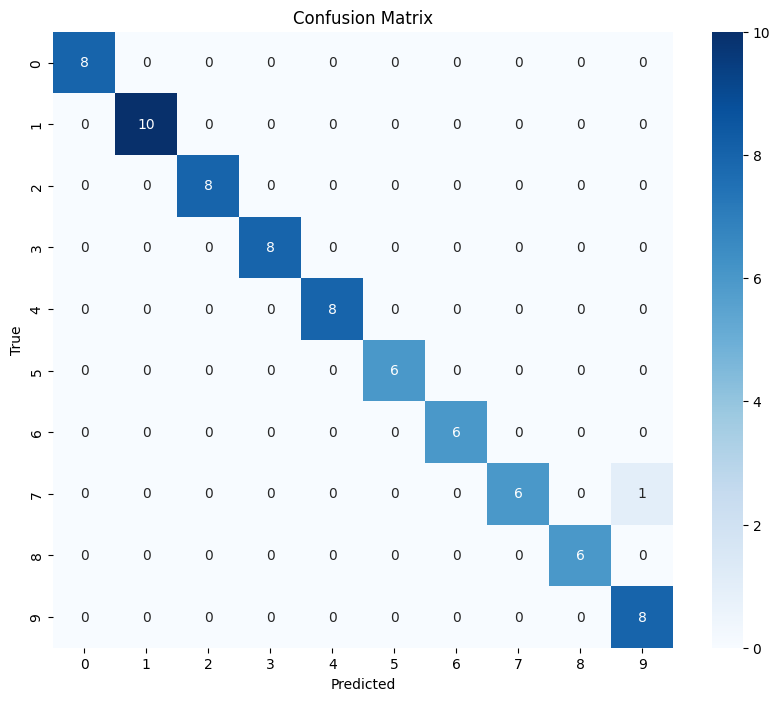

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      0.86      0.92         7
           8       1.00      1.00      1.00         6
           9       0.89      1.00      0.94         8

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



In [249]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_test = torch.tensor(X_labeled_test, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_test)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_test
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Jelmar

The null model has an accuracy of 13% and the final iteration version of the model has an accuracy of 99%, so it is signivicantly better.

The validation and test set is not very big, but because the final iteration model has the same accuracy on the validation data as the test data means that the test set is atleast reasonably relaible.